## Model Optimization for Diverse Classification Tasks

---
#### 2. Training and Testing on Baseline Models
---

Model: MobileNetv2

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken = 18 min 56 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs8_0.0001_lr model training...
Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.3493 - loss: 1.5716
Epoch 1: val_loss improved from inf to 1.57384, saving model to results\mobilenetv2_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 89s 423ms/step - accuracy: 0.3498 - loss: 1.5708 - val_accuracy: 0.4033 - val_loss: 1.5738
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4711 - loss: 1.3766
Epoch 2: val_loss improved from 1.57384 to 1.55361, saving model to results\mobilenetv2_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 61s 387ms/step - accuracy: 0.4712 - loss: 1.3765 - val_accuracy: 0.4033 - val_loss: 1.5536
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.4841 - loss: 1.3266
Epoch 3: val_loss improved from 1.55361 to 1.52095, saving model to results\mobilenetv2_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 61

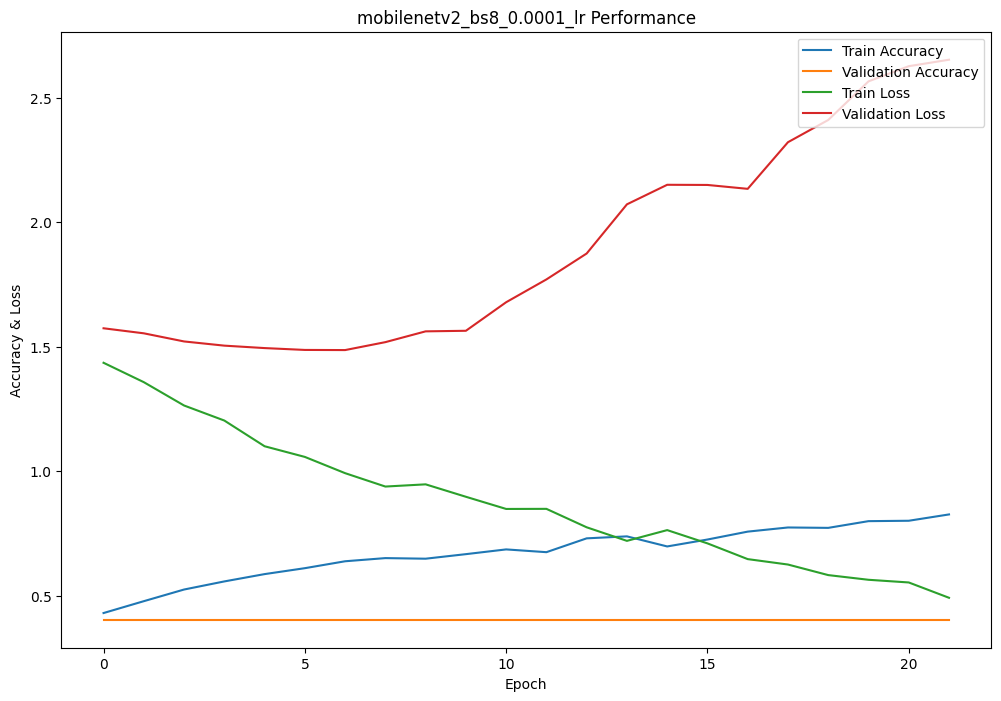


--- mobilenetv2_bs8_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- mobilenetv2_bs8_0.0001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\mobilenetv2_bs8_0.0001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

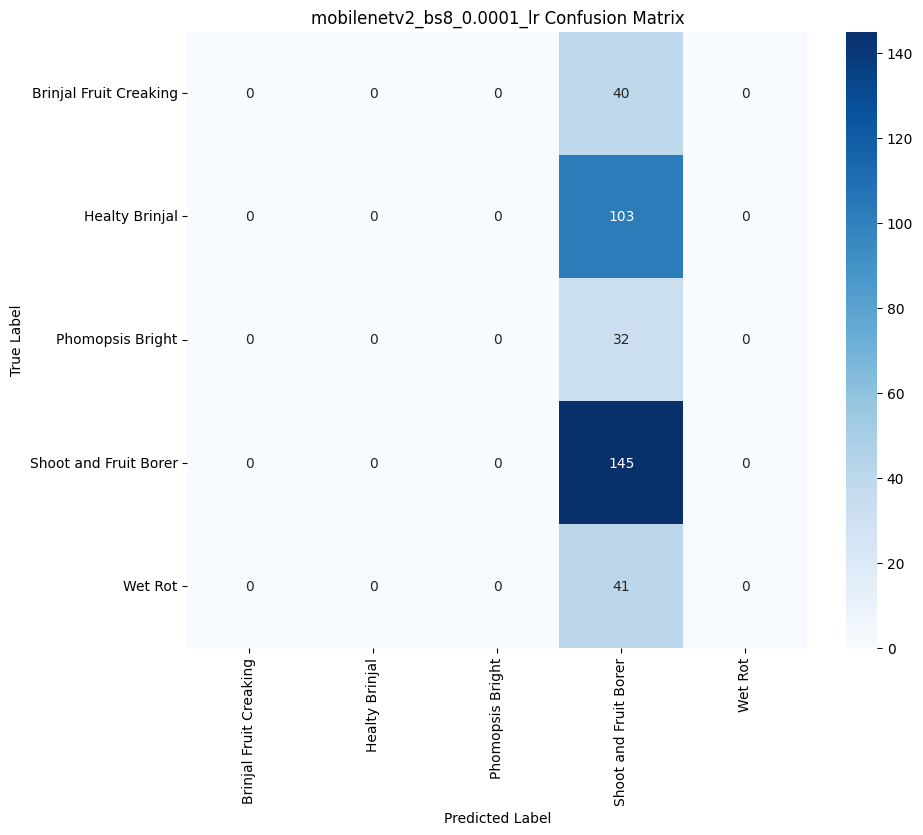


Updating summary results file...
Created new summary results file at results\summary_results.csv

The best version of mobilenetv2_bs8_0.0001_lr was saved to 'results\mobilenetv2_bs8_0.0001_lr\best_model.keras'


In [26]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 8

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.0001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken = 18 min 1 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs8_0.00001_lr model training...
Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.2720 - loss: 1.6605
Epoch 1: val_loss improved from inf to 1.59227, saving model to results\mobilenetv2_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 76s 359ms/step - accuracy: 0.2724 - loss: 1.6600 - val_accuracy: 0.4033 - val_loss: 1.5923
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.4067 - loss: 1.4988
Epoch 2: val_loss improved from 1.59227 to 1.56604, saving model to results\mobilenetv2_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 53s 334ms/step - accuracy: 0.4067 - loss: 1.4986 - val_accuracy: 0.4033 - val_loss: 1.5660
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.4427 - loss: 1.4460
Epoch 3: val_loss improved from 1.56604 to 1.54322, saving model to results\mobilenetv2_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━

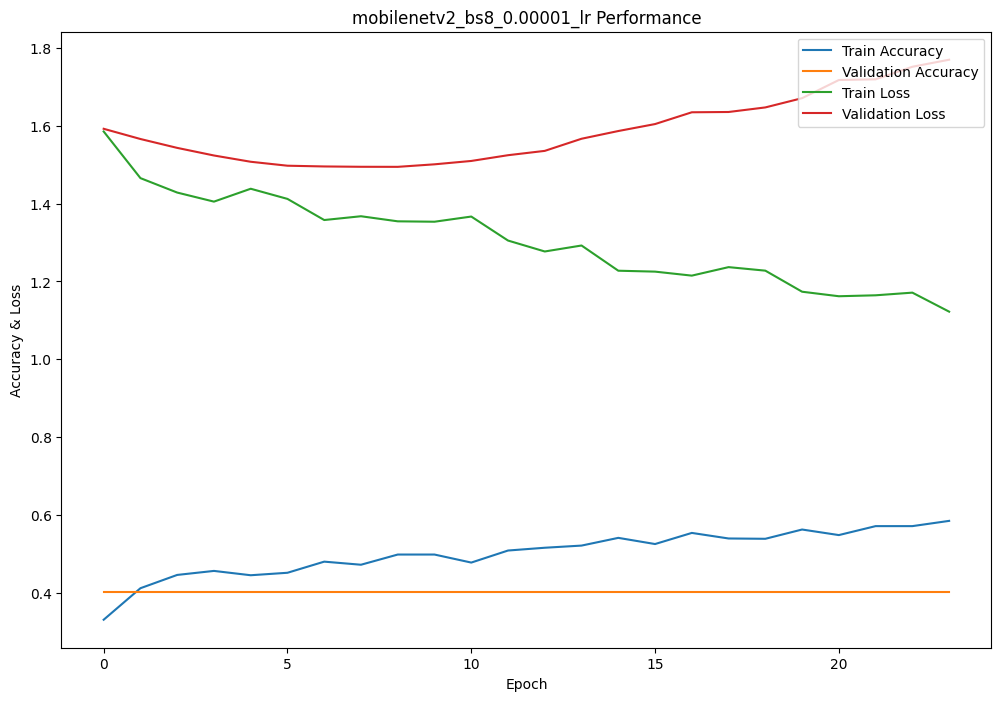


--- mobilenetv2_bs8_0.00001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- mobilenetv2_bs8_0.00001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\mobilenetv2_bs8_0.00001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

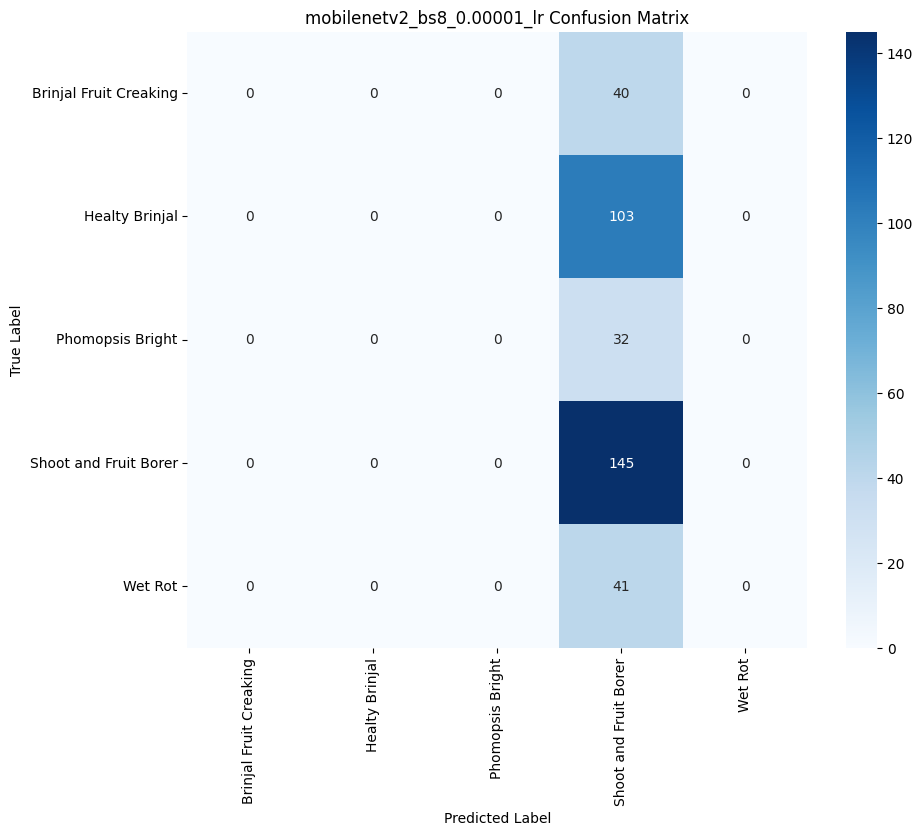


Updating summary results file...
Updated results for mobilenetv2_bs8_0.00001_lr in results\summary_results.csv

The best version of mobilenetv2_bs8_0.00001_lr was saved to 'results\mobilenetv2_bs8_0.00001_lr\best_model.keras'


In [27]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 8

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.00001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken = 14 min 52 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs16_0.0001_lr model training...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.3986 - loss: 1.5295
Epoch 1: val_loss improved from inf to 1.58469, saving model to results\mobilenetv2_bs16_0.0001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 618ms/step - accuracy: 0.3992 - loss: 1.5283 - val_accuracy: 0.4033 - val_loss: 1.5847
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.5216 - loss: 1.2801
Epoch 2: val_loss improved from 1.58469 to 1.56870, saving model to results\mobilenetv2_bs16_0.0001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 572ms/step - accuracy: 0.5215 - loss: 1.2799 - val_accuracy: 0.4033 - val_loss: 1.5687
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.5434 - loss: 1.1716
Epoch 3: val_loss improved from 1.56870 to 1.55397, saving model to results\mobilenetv2_bs16_0.0001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 564ms/

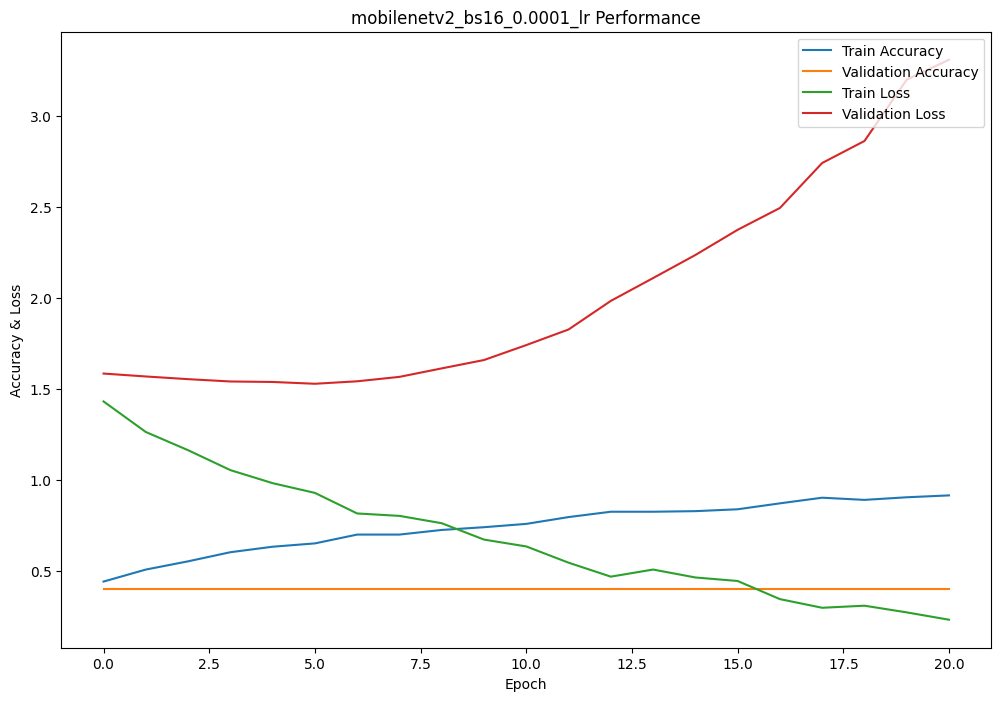


--- mobilenetv2_bs16_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- mobilenetv2_bs16_0.0001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\mobilenetv2_bs16_0.0001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

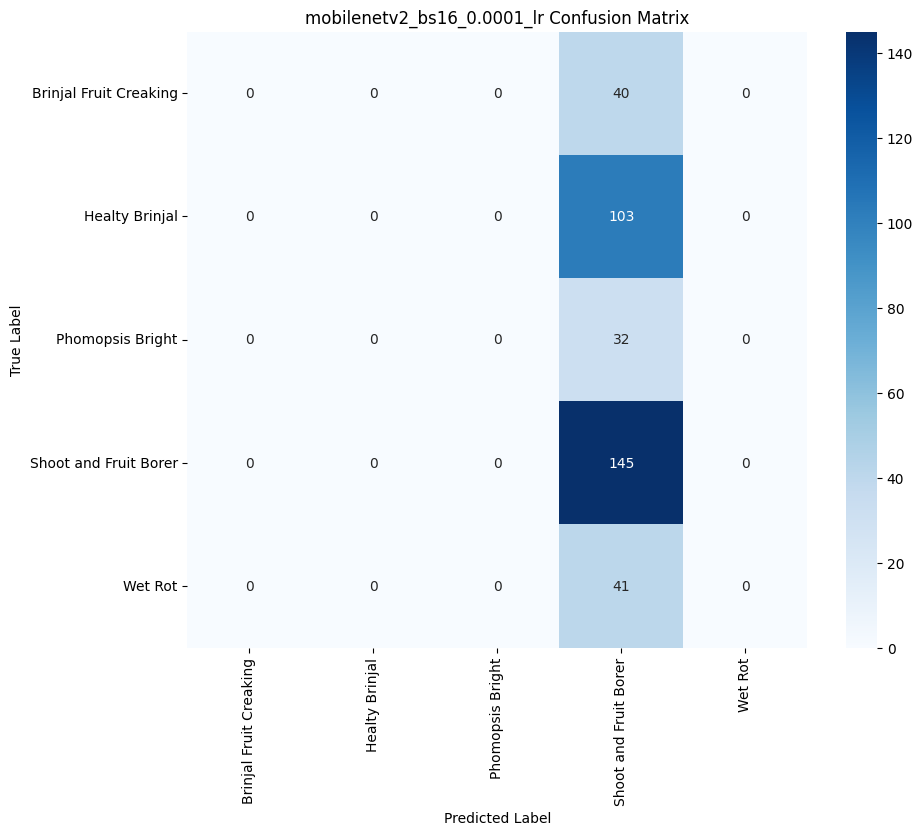


Updating summary results file...
Updated results for mobilenetv2_bs16_0.0001_lr in results\summary_results.csv

The best version of mobilenetv2_bs16_0.0001_lr was saved to 'results\mobilenetv2_bs16_0.0001_lr\best_model.keras'


In [28]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 16

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.0001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken = 14 min 52 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs16_0.00001_lr model training...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.3949 - loss: 1.5774
Epoch 1: val_loss improved from inf to 1.60147, saving model to results\mobilenetv2_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 614ms/step - accuracy: 0.3951 - loss: 1.5765 - val_accuracy: 0.4033 - val_loss: 1.6015
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.4394 - loss: 1.4638
Epoch 2: val_loss improved from 1.60147 to 1.58856, saving model to results\mobilenetv2_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 600ms/step - accuracy: 0.4396 - loss: 1.4636 - val_accuracy: 0.4033 - val_loss: 1.5886
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.4614 - loss: 1.4162
Epoch 3: val_loss improved from 1.58856 to 1.57562, saving model to results\mobilenetv2_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 58

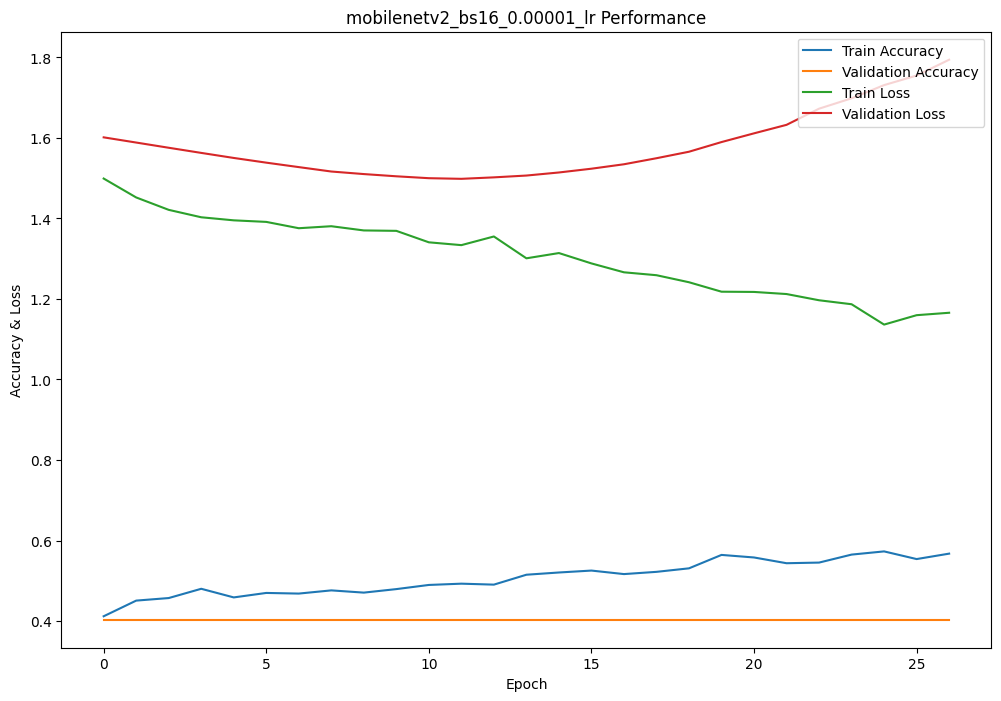


--- mobilenetv2_bs16_0.00001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- mobilenetv2_bs16_0.00001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\mobilenetv2_bs16_0.00001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

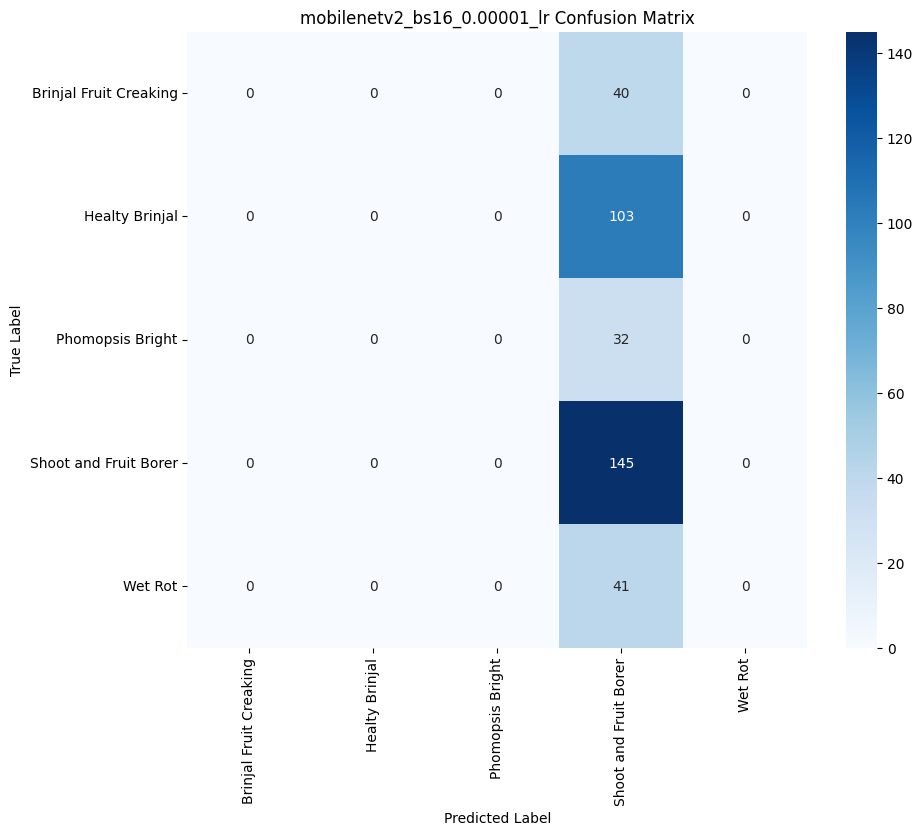


Updating summary results file...
Updated results for mobilenetv2_bs16_0.00001_lr in results\summary_results.csv

The best version of mobilenetv2_bs16_0.00001_lr was saved to 'results\mobilenetv2_bs16_0.00001_lr\best_model.keras'


In [29]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 16

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.00001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken = 13 min 08 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs32_0.0001_lr model training...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3867 - loss: 1.5222
Epoch 1: val_loss improved from inf to 1.59448, saving model to results\mobilenetv2_bs32_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.3876 - loss: 1.5210 - val_accuracy: 0.4033 - val_loss: 1.5945
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4960 - loss: 1.3594
Epoch 2: val_loss improved from 1.59448 to 1.58523, saving model to results\mobilenetv2_bs32_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4960 - loss: 1.3593 - val_accuracy: 0.4033 - val_loss: 1.5852
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5188 - loss: 1.2714
Epoch 3: val_loss improved from 1.58523 to 1.57469, saving model to results\mobilenetv2_bs32_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0

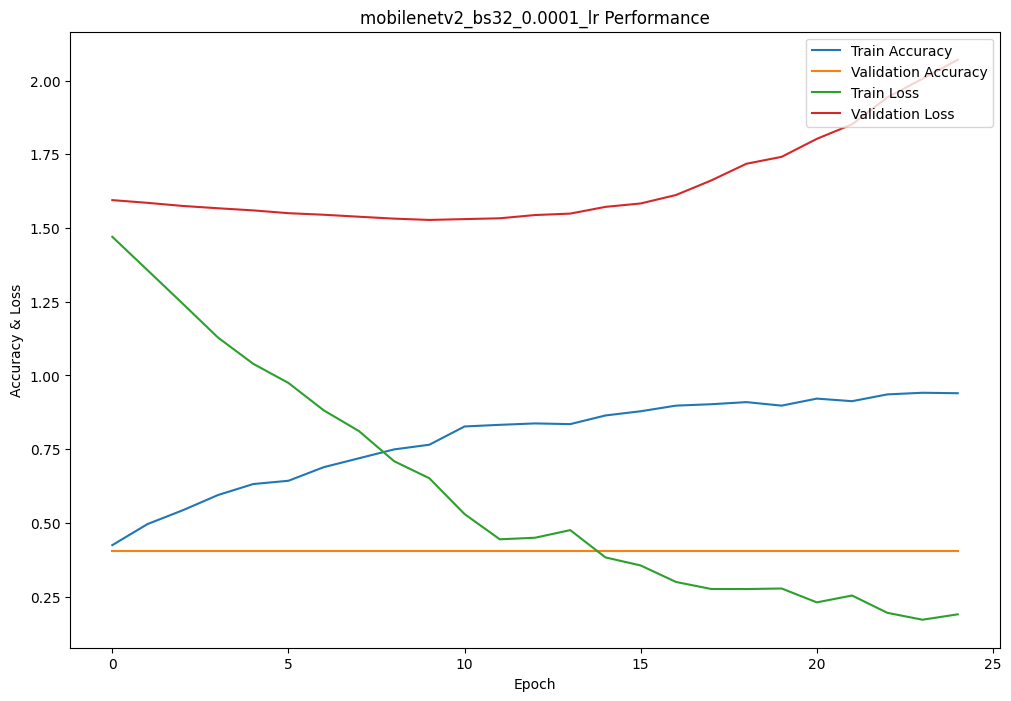


--- mobilenetv2_bs32_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- mobilenetv2_bs32_0.0001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\mobilenetv2_bs32_0.0001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

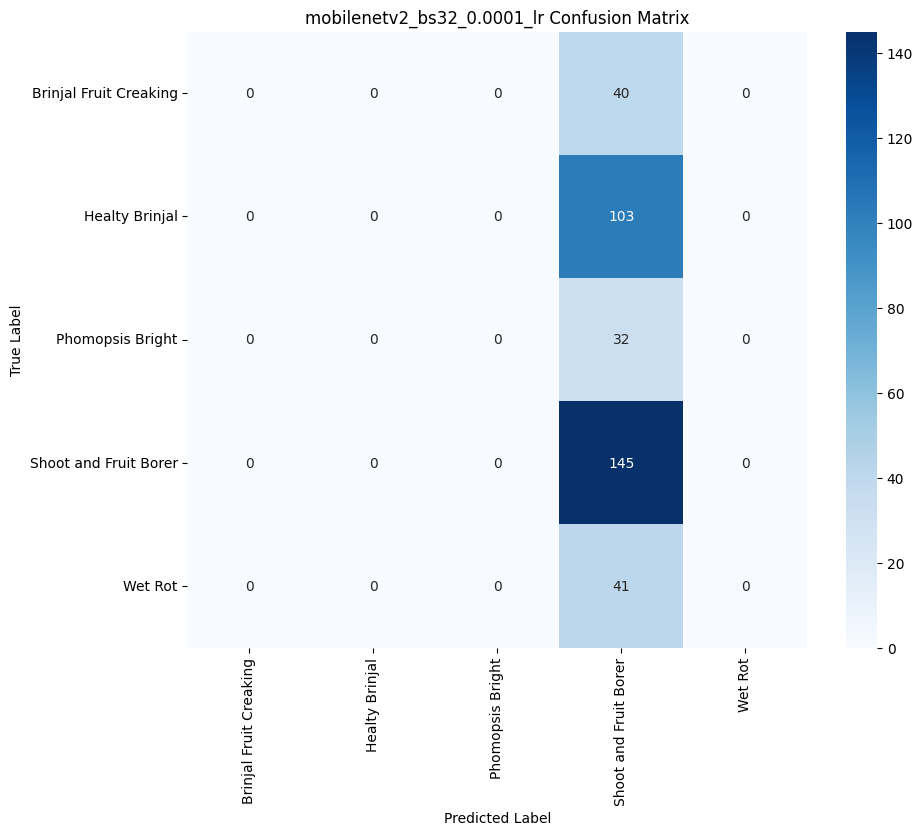


Updating summary results file...
Updated results for mobilenetv2_bs32_0.0001_lr in results\summary_results.csv

The best version of mobilenetv2_bs32_0.0001_lr was saved to 'results\mobilenetv2_bs32_0.0001_lr\best_model.keras'


In [30]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 32

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.0001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken = 13 min 4 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs32_0.00001_lr model training...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1850 - loss: 1.8401
Epoch 1: val_loss improved from inf to 1.60702, saving model to results\mobilenetv2_bs32_0.00001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.1853 - loss: 1.8388 - val_accuracy: 0.4033 - val_loss: 1.6070
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3177 - loss: 1.6258
Epoch 2: val_loss improved from 1.60702 to 1.60301, saving model to results\mobilenetv2_bs32_0.00001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3178 - loss: 1.6259 - val_accuracy: 0.4033 - val_loss: 1.6030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3823 - loss: 1.5191
Epoch 3: val_loss improved from 1.60301 to 1.59796, saving model to results\mobilenetv2_bs32_0.00001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accurac

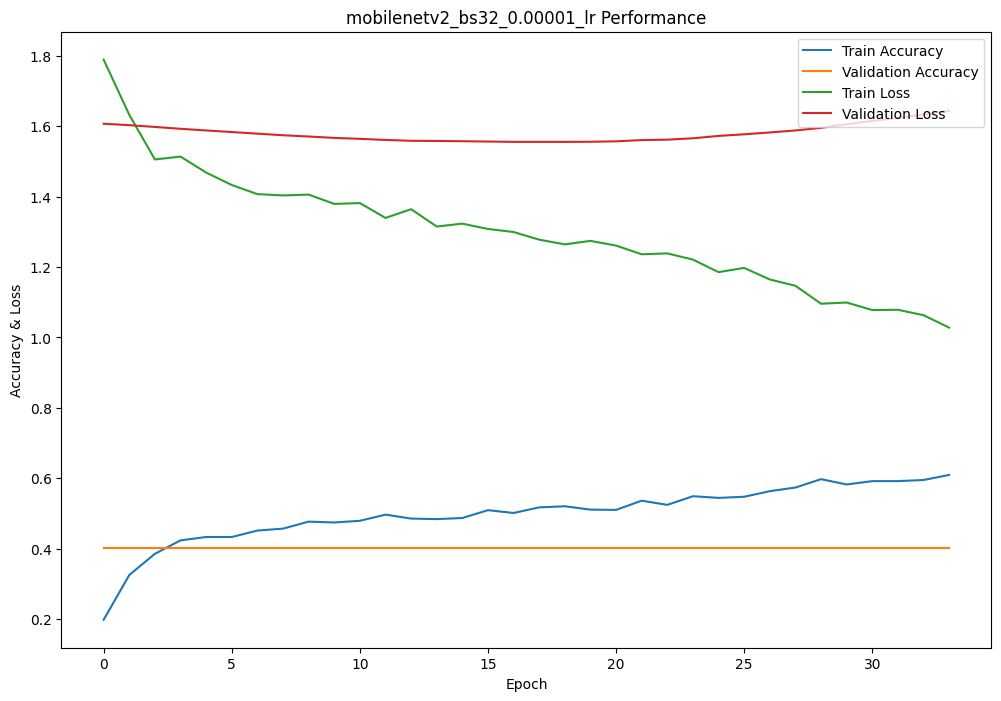


--- mobilenetv2_bs32_0.00001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- mobilenetv2_bs32_0.00001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\mobilenetv2_bs32_0.00001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

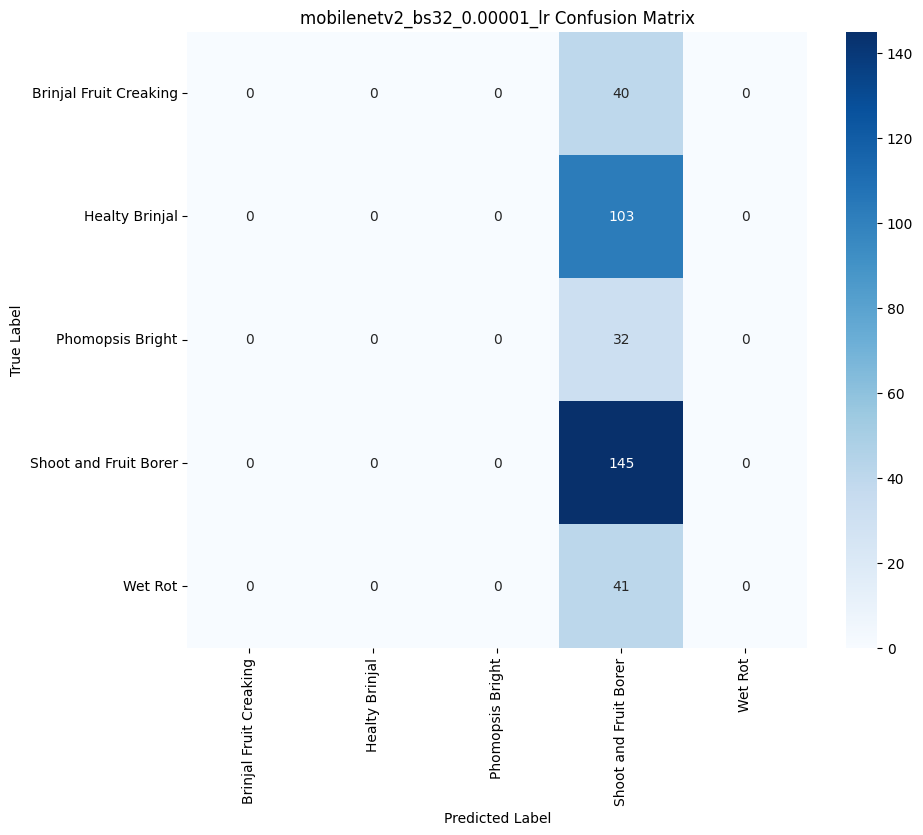


Updating summary results file...
Updated results for mobilenetv2_bs32_0.00001_lr in results\summary_results.csv

The best version of mobilenetv2_bs32_0.00001_lr was saved to 'results\mobilenetv2_bs32_0.00001_lr\best_model.keras'


In [31]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 32

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.00001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: EfficientNetB0 

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

Loading preprocessed data...
Data loaded successfully.

Starting efficientnetb0_bs8_0.0001_lr model training...
Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.4311 - loss: 1.5289
Epoch 1: val_loss improved from inf to 1.49404, saving model to results\efficientnetb0_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 122s 598ms/step - accuracy: 0.4311 - loss: 1.5286 - val_accuracy: 0.4033 - val_loss: 1.4940
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.4923 - loss: 1.3692
Epoch 2: val_loss did not improve from 1.49404
158/158 ━━━━━━━━━━━━━━━━━━━━ 88s 555ms/step - accuracy: 0.4924 - loss: 1.3692 - val_accuracy: 0.4033 - val_loss: 1.5189
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.5383 - loss: 1.2772
Epoch 3: val_loss did not improve from 1.49404
158/158 ━━━━━━━━━━━━━━━━━━━━ 88s 557ms/step - accuracy: 0.5384 - loss: 1.2773 - val_accuracy: 0.4033 - val_loss: 2.2419
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 548m

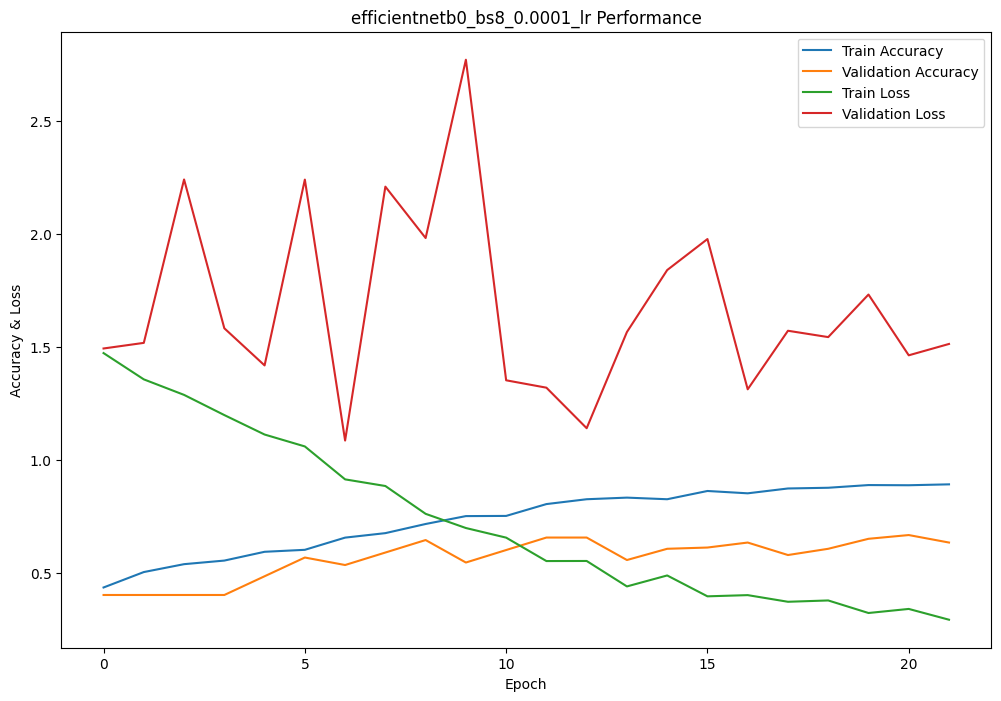


--- efficientnetb0_bs8_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 658ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.50      0.05      0.09        20
        Healty Brinjal       0.71      0.52      0.60        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.57      0.85      0.69        73
               Wet Rot       0.23      0.35      0.27        20

              accuracy                           0.54       181
             macro avg       0.40      0.35      0.33       181
          weighted avg       0.52      0.54      0.49       181


--- efficientnetb0_bs8_0.0001_lr Final Test Set Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.86      0.15      0.26        40
        He

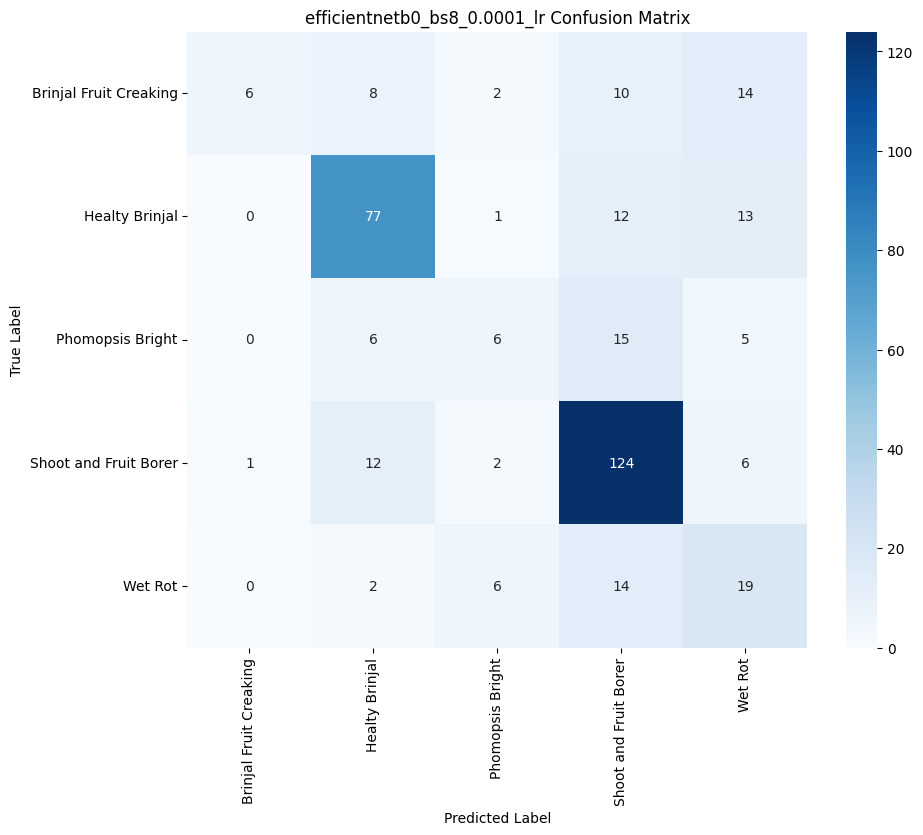


Updating summary results file...
Updated results for efficientnetb0_bs8_0.0001_lr in results\summary_results.csv

The best version of efficientnetb0_bs8_0.0001_lr was saved to 'results\efficientnetb0_bs8_0.0001_lr\best_model.keras'


In [32]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB0 

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

Loading preprocessed data...
Data loaded successfully.

Starting efficientnetb0_bs8_0.00001_lr model training...
Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.3030 - loss: 1.6450
Epoch 1: val_loss improved from inf to 1.53411, saving model to results\efficientnetb0_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 129s 649ms/step - accuracy: 0.3032 - loss: 1.6448 - val_accuracy: 0.4033 - val_loss: 1.5341
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.3967 - loss: 1.5126
Epoch 2: val_loss improved from 1.53411 to 1.51706, saving model to results\efficientnetb0_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 100s 636ms/step - accuracy: 0.3966 - loss: 1.5126 - val_accuracy: 0.4033 - val_loss: 1.5171
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.4161 - loss: 1.4856
Epoch 3: val_loss did not improve from 1.51706
158/158 ━━━━━━━━━━━━━━━━━━━━ 99s 624ms/step - accuracy: 0.4161 - loss: 1.4856 - val_accur

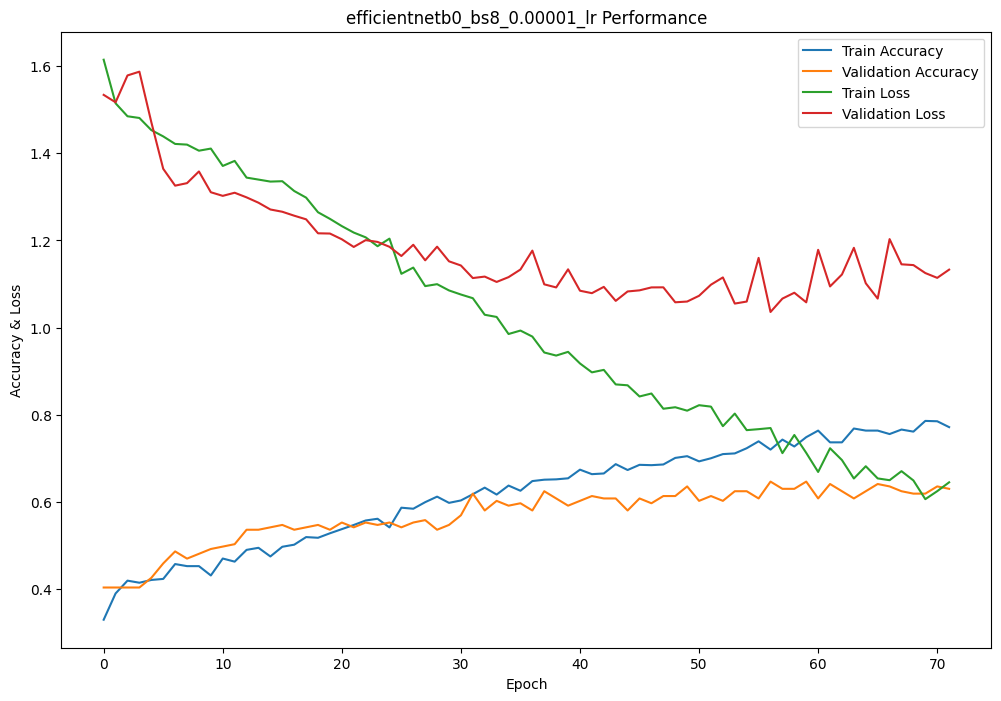


--- efficientnetb0_bs8_0.00001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 620ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.50      0.25      0.33        20
        Healty Brinjal       0.73      0.73      0.73        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.71      0.89      0.79        73
               Wet Rot       0.36      0.45      0.40        20

              accuracy                           0.65       181
             macro avg       0.46      0.46      0.45       181
          weighted avg       0.59      0.65      0.61       181


--- efficientnetb0_bs8_0.00001_lr Final Test Set Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.68      0.57      0.62        40
        

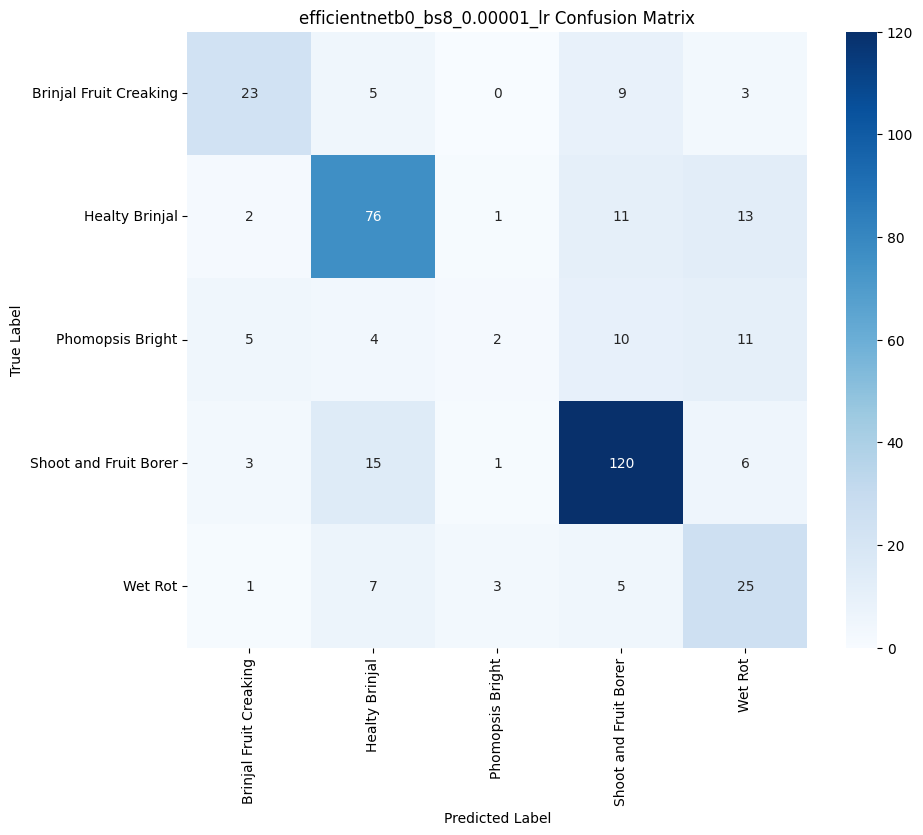


Updating summary results file...
Updated results for efficientnetb0_bs8_0.00001_lr in results\summary_results.csv

The best version of efficientnetb0_bs8_0.00001_lr was saved to 'results\efficientnetb0_bs8_0.00001_lr\best_model.keras'


In [33]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB0 

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

Loading preprocessed data...
Data loaded successfully.

Starting efficientnetb0_bs16_0.0001_lr model training...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3769 - loss: 1.6038
Epoch 1: val_loss improved from inf to 1.49082, saving model to results\efficientnetb0_bs16_0.0001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.3773 - loss: 1.6029 - val_accuracy: 0.4033 - val_loss: 1.4908
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4526 - loss: 1.4447
Epoch 2: val_loss did not improve from 1.49082
79/79 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4527 - loss: 1.4445 - val_accuracy: 0.4033 - val_loss: 1.5179
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4881 - loss: 1.3520
Epoch 3: val_loss did not improve from 1.49082
79/79 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4881 - loss: 1.3519 - val_accuracy: 0.4033 - val_loss: 1.6047
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5269 - loss:

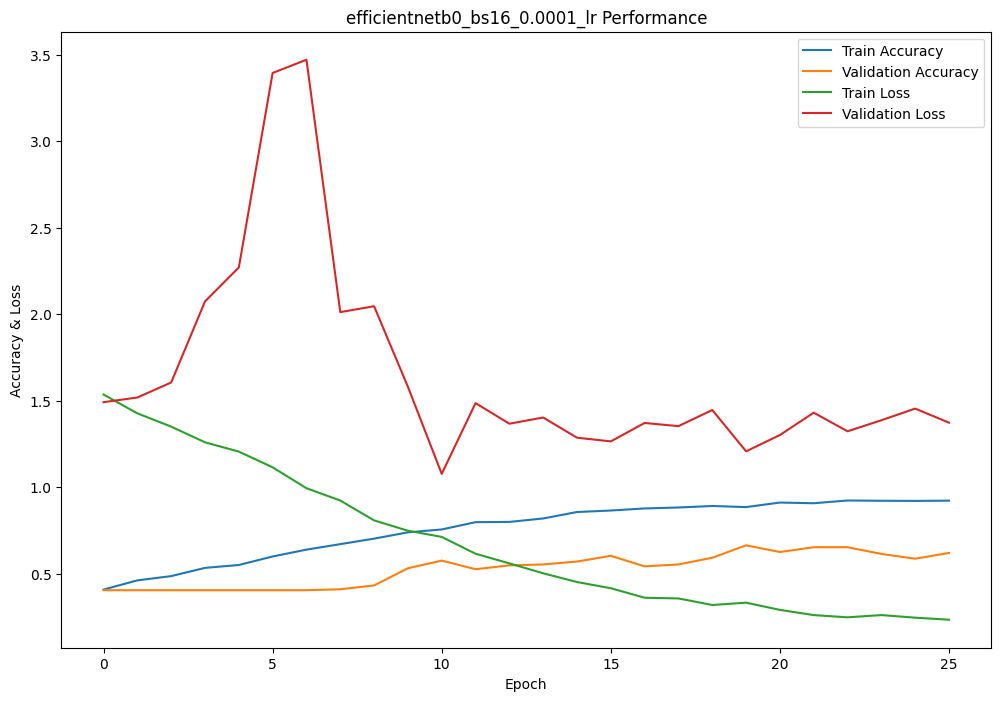


--- efficientnetb0_bs16_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.72      0.56      0.63        52
      Phomopsis Bright       0.23      0.19      0.21        16
 Shoot and Fruit Borer       0.58      0.96      0.73        73
               Wet Rot       0.25      0.10      0.14        20

              accuracy                           0.57       181
             macro avg       0.36      0.36      0.34       181
          weighted avg       0.49      0.57      0.51       181


--- efficientnetb0_bs16_0.0001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 346ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       1.00      0.17      0.30        40
        Healty Brinjal       0.62      0.57      0.60       103
      Phomopsis Bright       0.15      0.12      0.14        32
 Shoot and Fruit Borer       0.62      0.94      0.74       145
               Wet Rot       0.25      0.07      0.11        41

              accuracy                           0.58       361
             macro avg       0.53      0.38      0.38       361
          weighted avg       0.58      0.58      0.53       361

Test classification report saved to results\efficientnetb0_bs16_0.0001_lr\classification_report.csv


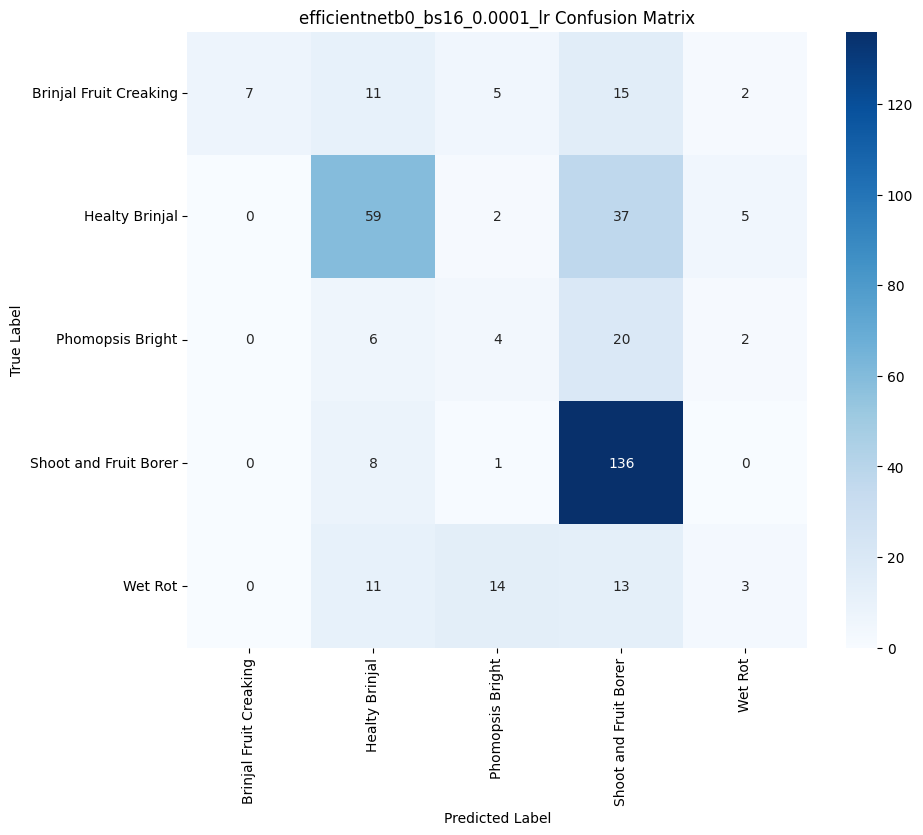


Updating summary results file...
Updated results for efficientnetb0_bs16_0.0001_lr in results\summary_results.csv

The best version of efficientnetb0_bs16_0.0001_lr was saved to 'results\efficientnetb0_bs16_0.0001_lr\best_model.keras'


In [34]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB0 

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Loading preprocessed data...
Data loaded successfully.

Starting efficientnetb0_bs16_0.00001_lr model training...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1747 - loss: 1.8046
Epoch 1: val_loss improved from inf to 1.59077, saving model to results\efficientnetb0_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.1751 - loss: 1.8039 - val_accuracy: 0.4033 - val_loss: 1.5908
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3002 - loss: 1.6717
Epoch 2: val_loss improved from 1.59077 to 1.55227, saving model to results\efficientnetb0_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.3004 - loss: 1.6719 - val_accuracy: 0.4033 - val_loss: 1.5523
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3692 - loss: 1.5933
Epoch 3: val_loss improved from 1.55227 to 1.53403, saving model to results\efficientnetb0_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/s

Model: EfficientNetB0 

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB0 

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: Inceptionv3

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: Inceptionv3

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: Inceptionv3

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: Inceptionv3

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: Inceptionv3

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: Inceptionv3

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: VGG16

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG16

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG16

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG16

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG16

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG16

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: ResNet50

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet50

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet50

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet50

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet50

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet50

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: MobileNetV3

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetV3

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetV3

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetV3

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetV3

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetV3

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: EfficientNetB7

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB7

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB7

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB7

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB7

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB7

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: InceptionResNetV2

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: InceptionResNetV2

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: InceptionResNetV2

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: InceptionResNetV2

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: InceptionResNetV2

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: InceptionResNetV2

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: VGG19

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG19

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG19

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG19

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG19

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG19

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: ResNet152

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet152

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet152

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet152

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet152

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet152

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights=None)
base_model.trainable = True
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: Adaptive

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken = 